In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set()

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, confusion_matrix, classification_report, precision_score, ConfusionMatrixDisplay, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, cross_validate, RepeatedStratifiedKFold, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('./data/data_clean.csv')
df

,annual_income,birthday,days_employment,family_size,work_phone,phone,email,car,property,education,...,occupation_Realty agents,occupation_Private service staff,marital_Single / not married,marital_Married,marital_Civil marriage,marital_Separated,marital_Widow,label,ID,window
0,427500.0,-12005,-4542,2.0,1,0,0,1.0,1.0,3.0,...,0,0,0,0,1,0,0,0.0,5008804,15.0
1,427500.0,-12005,-4542,2.0,1,0,0,1.0,1.0,3.0,...,0,0,0,0,1,0,0,0.0,5008805,14.0
2,112500.0,-21474,-1134,2.0,0,0,0,1.0,1.0,1.0,...,0,0,0,1,0,0,0,0.0,5008806,29.0
3,270000.0,-19110,-3051,1.0,0,1,1,0.0,1.0,1.0,...,0,0,1,0,0,0,0,0.0,5008808,4.0
4,270000.0,-19110,-3051,1.0,0,1,1,0.0,1.0,1.0,...,0,0,1,0,0,0,0,0.0,5008809,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,135000.0,-22717,0,1.0,0,0,0,0.0,1.0,1.0,...,0,0,0,0,0,1,0,NaN,6840104,NaN
438553,103500.0,-15939,-3007,1.0,0,0,0,0.0,0.0,1.0,...,0,0,1,0,0,0,0,NaN,6840222,NaN
438554,54000.0,-8169,-372,1.0,1,0,0,0.0,0.0,3.0,...,0,0,1,0,0,0,0,NaN,6841878,NaN
438555,72000.0,-21673,0,2.0,0,0,0,0.0,1.0,1.0,...,0,0,0,1,0,0,0,NaN,6842765,NaN


In [3]:
df.dropna(inplace=True)

In [ ]:
df

In [4]:
df.label.value_counts() # base rate = 1.7%

0.0    35841
1.0      616
Name: label, dtype: int64

**Just learning from the users who have long than 3 months of records.** 

In [4]:
df_3m = df.loc[df.window >= 3]

In [5]:
df_3m.label.value_counts() # base rate = 1.8%

0.0    33512
1.0      615
Name: label, dtype: int64

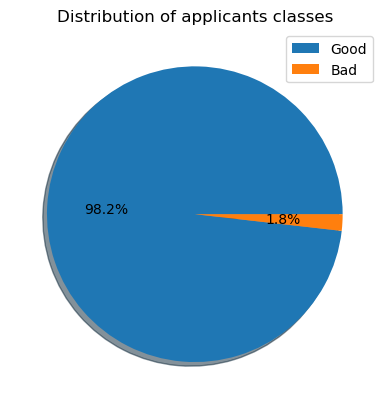

In [11]:
plt.pie(df_3m['label'].value_counts(), autopct='%1.1f%%', 
        shadow=True)
plt.title('Distribution of applicants classes')
plt.legend(['Good', 'Bad'])

**The old model predicted all the applicants in the dataset df_3m as 'good' client.**  
- We labeled the credit card users who overdue for more than 60 days as risk clients.
- The money loss predicted by the old model is: 0 
-The precision of our new model will represent how many 'bad' clients we can predict. The money loss can be predicted as: FN * loss_aver + FP * gain_aver, loss_aver is the average of money loss caused by a 'bad' client, gain_aver is the money gain brought by a 'good' client on average. 
-So how to evalute the model's performance depends on the money loss of one bad client and money gain of one good client. We can talk with other teams to discuss how to do feature engineering, select model and tune model.

In [ ]:
33512 / (33512+515)

# Scaling data and Processing imbalance dataset

**Oversample the minority class using SMOTE**

In [7]:
numeric_features = ['annual_income', 'birthday', 'days_employment', 'family_size']
scaler = ColumnTransformer(
    transformers=[('num_scaler', StandardScaler(), numeric_features)],
    remainder='passthrough'
)
#oversample = SMOTE(random_state=1) # sampling_strategy: can try to tune

# Model Selection

**Using repeated stratified Kfold to evaluate.**
- Both StratifiedKFold and RepeatedStratifiedKFold can be very effective when used on classification problems with a severe class imbalance. They both stratify the sampling by the class label; that is, they split the dataset in such a way that preserves approximately the same class distribution (i.e., the same percentage of samples of each class) in each subset/fold as in the original dataset. 
- However, a single run of StratifiedKFold might result in a noisy estimate of the model's performance, as different splits of the data might result in very different results. That is where RepeatedStratifiedKFold comes into play.

In [8]:
features = list(df_3m.columns)
target = 'label'
features.remove('ID')
features.remove('window')
features.remove(target)
features

['annual_income',
 'birthday',
 'days_employment',
 'family_size',
 'work_phone',
 'phone',
 'email',
 'car',
 'property',
 'education',
 'gender',
 'income_Student',
 'income_Pensioner',
 'income_State servant',
 'income_Commercial associate',
 'income_Working',
 'housing_Municipal apartment',
 'housing_With parents',
 'housing_Office apartment',
 'housing_Rented apartment',
 'housing_House / apartment',
 'housing_Co-op apartment',
 'occupation_Cleaning staff',
 'occupation_others',
 'occupation_Security staff',
 'occupation_Medicine staff',
 'occupation_Managers',
 'occupation_Sales staff',
 'occupation_Cooking staff',
 'occupation_Core staff',
 'occupation_Laborers',
 'occupation_Low-skill Laborers',
 'occupation_Waiters/barmen staff',
 'occupation_IT staff',
 'occupation_Accountants',
 'occupation_Secretaries',
 'occupation_High skill tech staff',
 'occupation_Drivers',
 'occupation_Realty agents',
 'occupation_Private service staff',
 'marital_Single / not married',
 'marital_Marr

In [9]:
X = df_3m[features]
y = df_3m[target]

In [10]:
output = pd.concat([X, y], axis=1)
output.to_csv('./flask/model/model_trainset.csv', index=False)

## Using ROC_AUC as metric to choose models

**1. Logistic Regression**

In [20]:
# define pipeline
steps = [('over', SMOTE()), 
         ('scaler', scaler),
         ('model', LogisticRegression(tol=0.001, max_iter=10000, n_jobs=-1))]
pipeline = Pipeline(steps=steps)
Pipeline(steps=steps)

Pipeline(steps=[('over', SMOTE()),
                ('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_scaler',
                                                  StandardScaler(),
                                                  ['annual_income', 'birthday',
                                                   'days_employment',
                                                   'family_size'])])),
                ('model',
                 LogisticRegression(max_iter=10000, n_jobs=-1, tol=0.001))])

In [12]:
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))
print(scores)

#scores = cross_validate(pipeline, X, y, scoring=('roc_auc', 'precision') , cv=cv, n_jobs=-1)
#print(scores)

Mean ROC AUC: 0.557
[0.53582366 0.53616024 0.54517824 0.56914512 0.57075609 0.57559714
 0.5833494  0.53203449 0.58586322 0.53940821]


**2. SVM**

In [13]:
steps = [('over', SMOTE()), 
         ('scaler', scaler),
         ('model', SVC(kernel='rbf'))]
pipeline = Pipeline(steps=steps)
Pipeline(steps=steps)

Pipeline(steps=[('over', SMOTE()),
                ('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_scaler',
                                                  StandardScaler(),
                                                  ['annual_income', 'birthday',
                                                   'days_employment',
                                                   'family_size'])])),
                ('model', SVC())])

In [14]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.650


**3. Random Forest**

In [16]:
steps = [('over', SMOTE()), 
         ('scaler', scaler),
         ('model', RandomForestClassifier(min_samples_split=10, min_samples_leaf=5))]
pipeline = Pipeline(steps=steps)
Pipeline(steps=steps)

Pipeline(steps=[('over', SMOTE()),
                ('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_scaler',
                                                  StandardScaler(),
                                                  ['annual_income', 'birthday',
                                                   'days_employment',
                                                   'family_size'])])),
                ('model',
                 RandomForestClassifier(min_samples_leaf=5,
                                        min_samples_split=10))])

In [17]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.762


**4. XGBoost**

In [18]:
steps = [('over', SMOTE()), 
         ('scaler', scaler),
         ('model', XGBClassifier(learning_rate=1, objective='binary:logistic'))]
pipeline = Pipeline(steps=steps)
Pipeline(steps=steps)

Pipeline(steps=[('over', SMOTE()),
                ('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_scaler',
                                                  StandardScaler(),
                                                  ['annual_income', 'birthday',
                                                   'days_employment',
                                                   'family_size'])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [19]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.761


# Tune model & Evaluate model using cross validation
- Compare with Logistic Regression model

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)

**Logistic Regression**

In [22]:
steps = [('over', SMOTE()), 
         ('scaler', scaler),
         ('model', LogisticRegression(tol=0.001, max_iter=10000, n_jobs=-1, random_state=1,
                                      solver='sag'))]
param = {#'model__solver': ['lbfgs', 'sag', 'saga', 'newton-cg'], #sag
         'model__C': np.arange(0.01, 1, 0.05)  # 0.56  
        }

#scorer = make_scorer(precision_score)
scorer = make_scorer(roc_auc_score)
model_tuned = GridSearchCV(
    estimator=Pipeline(steps),
    param_grid=param,
    scoring=scorer,
    n_jobs = -1,
    cv=3).fit(X_train, y_train)

print('Tunning results of Logistic Regression: ', model_tuned.best_params_)
print('Tunning results of Logistic Regression: ', model_tuned.best_score_)

Tunning results of Logistic Regression:  {'model__C': 0.01}
Tunning results of Logistic Regression:  0.5133559885079974


**XGBoost**

In [14]:
steps = [('over', SMOTE()), 
         ('scaler', scaler),
         ('model', XGBClassifier(objective='binary:logistic', 
                                 learning_rate=0.5, max_depth=8,
                                 n_estimators=250, min_child_weight=4))]
param = {#'model__learning_rate': [0.005, 0.05, 0.1, 0.5, 1],  # 0.5
         #'model__gamma': [0, 0.5, 1, 1.5, 2],  # 0
         #'model__max_depth': np.arange(3, 10),  # 8
         #'model__n_estimators': [100, 200, 250, 300, 400], # 250
         #'model__lambda': [1, 1.5, 2],
         #'model__subsample': [1, 0.8],
         'model__min_child_weight': np.arange(1, 10)  # 4
        }

scorer = make_scorer(precision_score)
model_tuned = GridSearchCV(
    estimator=Pipeline(steps),
    param_grid=param,
    scoring=scorer,
    n_jobs = -1,
    cv=3).fit(X_train, y_train)

print('Tunning results: ', model_tuned.best_params_)

Tunning results:  {'model__min_child_weight': 2}


In [ ]:
y_train_pred = model_tuned.best_estimator_.predict(X_train)
y_test_pred = model_tuned.best_estimator_.predict(X_test)
print('Classification metrics of Train data: \n', classification_report(y_train, y_train_pred))
print('Classification metrics of Test data: \n', classification_report(y_test, y_test_pred))
print('---------------------------------------')
print('Confusion matrix of Train data: \n', confusion_matrix(y_train, y_train_pred, labels=[1, 0]))
print('Confusion matrix of Test data: \n', confusion_matrix(y_test, y_test_pred, labels=[1, 0]))

**Model evaluation**  
Compare XGBoost and Logistic Regression by Cross Validation

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1) #, stratify=y)

steps = [('over', SMOTE(random_state=1)), 
         ('scaler', scaler),
         ('model', XGBClassifier(objective='binary:logistic', 
                                 learning_rate=0.001, max_depth=3,
                                 n_estimators=250, min_child_weight=4,
                                 subsample=0.8
                                ))]

xgb_cv = cross_validate(Pipeline(steps), X_train, y_train, cv=10, 
                        scoring=('roc_auc'),
                        return_train_score=True)

In [23]:
xgb_cv.keys()

dict_keys(['fit_time', 'score_time', 'test_score', 'train_score'])

In [17]:
xgb_cv['train_score']

array([0.67437084, 0.67303749, 0.67159331, 0.66610982, 0.67163122,
       0.65608103, 0.66371173, 0.66923819, 0.66983863, 0.6749196 ])

[0.59296085 0.61702302 0.61015974 0.6027932  0.59825813 0.59988054
 0.60751841 0.59767458 0.62282897 0.58792051]
[0.58026771 0.54923758 0.54952545 0.47699791 0.57136992 0.60899173
 0.5731383  0.48016754 0.55227673 0.56357992]


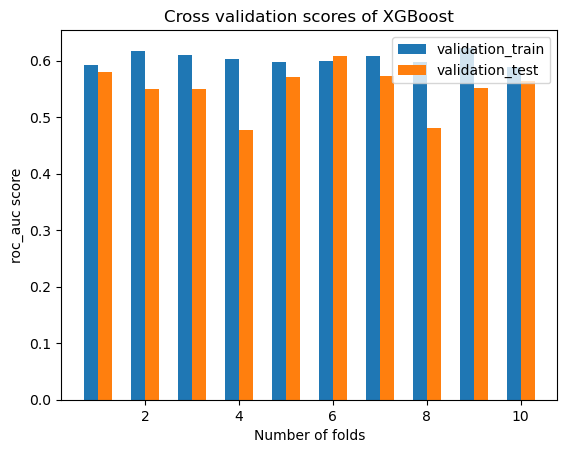

In [45]:
plt.bar(np.arange(1, 11)-0.15,
        xgb_cv['train_score'],
        width=0.3, label='validation_train')
plt.bar(np.arange(1, 11)+0.15,
        xgb_cv['test_score'],
        width=0.3, label='validation_test')
plt.xlabel('Number of folds')
plt.ylabel('roc_auc score')
plt.legend()
plt.title('Cross validation scores of XGBoost')

print(xgb_cv['train_score'])
print(xgb_cv['test_score'])

In [30]:
# Logistic regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1) #, stratify=y)

steps = [('over', SMOTE()), 
         ('scaler', scaler),
         ('model', LogisticRegression(tol=0.0001, max_iter=1000000, n_jobs=-1, random_state=1,
                                      solver='sag', C=0.56))]

lr_cv = cross_validate(Pipeline(steps), X_train, y_train, cv=10, 
                       scoring=('roc_auc'),
                       return_train_score=True)

[0.62275354 0.62405276 0.60998304 0.61962244 0.61621269 0.61128868
 0.61457104 0.61091442 0.61220463 0.61265209]
[0.57053534 0.51948591 0.62057302 0.64035546 0.54786608 0.58717729
 0.58071046 0.52598167 0.58353097 0.56477843]


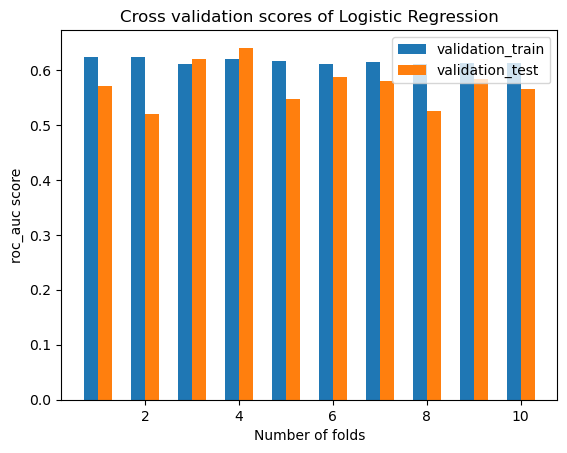

In [46]:
plt.bar(np.arange(1, 11)-0.15,
        lr_cv['train_score'],
        width=0.3, label='validation_train')
plt.bar(np.arange(1, 11)+0.15,
        lr_cv['test_score'],
        width=0.3, label='validation_test')
plt.xlabel('Number of folds')
plt.ylabel('roc_auc score')
plt.legend()
plt.title('Cross validation scores of Logistic Regression')

print(lr_cv['train_score'])
print(lr_cv['test_score'])

**Test the tuned model**

In [31]:
# XGBoost
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)#, stratify=y)

steps = [('over', SMOTE()), 
         ('scaler', scaler),
         ('model', XGBClassifier(objective='binary:logistic', random_state=1,
                                 learning_rate=0.5, max_depth=8,
                                 n_estimators=250, min_child_weight=4))]
'''

steps = [('over', SMOTE()), 
         ('scaler', scaler),
         ('model', XGBClassifier(objective='binary:logistic', 
                                 learning_rate=0.02, max_depth=12,
                                 n_estimators=250, min_child_weight=8,
                                 subsample=0.8))]
'''

model = Pipeline(steps).fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('Classification metrics of Train data: \n', classification_report(y_train, y_train_pred))
print('Classification metrics of Test data: \n', classification_report(y_test, y_test_pred))
#print('---------------------------------------')
#print('Confusion matrix of Train data: \n', confusion_matrix(y_train, y_train_pred, labels=[1, 0]))
#print('Confusion matrix of Test data: \n', confusion_matrix(y_test, y_test_pred, labels=[1, 0]))

Classification metrics of Train data: 
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     25123
         1.0       0.68      0.72      0.70       472

    accuracy                           0.99     25595
   macro avg       0.84      0.86      0.85     25595
weighted avg       0.99      0.99      0.99     25595

Classification metrics of Test data: 
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      8389
         1.0       0.40      0.32      0.36       143

    accuracy                           0.98      8532
   macro avg       0.69      0.66      0.67      8532
weighted avg       0.98      0.98      0.98      8532



Text(0.5, 1.0, 'Normalized Confusion Matrix of XGBoost on Test Dataset')

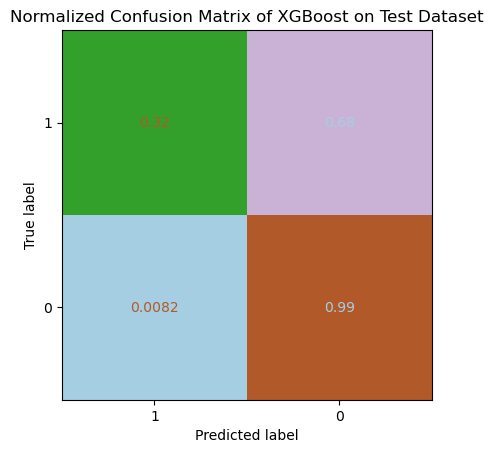

In [32]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test,
                                      labels = [1, 0], cmap=plt.cm.Paired,
                                      colorbar=False, normalize='true')
plt.title('Normalized Confusion Matrix of XGBoost on Test Dataset')
#ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred)).plot()

Text(0.5, 1.0, 'Normalized Confusion Matrix of Logistic Regression on Test Dataset')

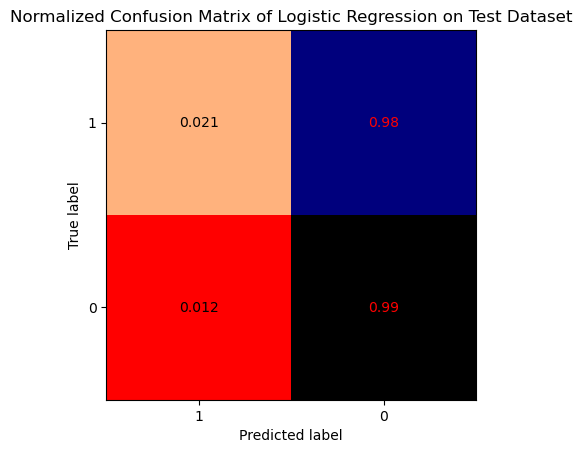

In [34]:
# Logistic Regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)#, stratify=y)

steps = [('over', SMOTE()), 
         ('scaler', scaler),
         ('model', LogisticRegression(tol=0.001, max_iter=10000, n_jobs=-1, random_state=1,
                                      solver='sag', C=0.56))]
model = Pipeline(steps).fit(X_train, y_train)

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test,
                                      labels = [1, 0],
                                      colorbar=False, cmap=plt.cm.flag,
                                      normalize='true')
plt.title('Normalized Confusion Matrix of Logistic Regression on Test Dataset')

**Random Forest**

In [ ]:
steps = [('over', SMOTE()), 
         ('scaler', scaler),
         ('model', RandomForestClassifier())] #min_samples_split=15, min_samples_leaf=5)

param = {#'model__min_samples_split': np.arange(3, 20), # 15
         'model__min_samples_leaf': np.arange(5, 30), # 5
         'model__max_depth': np.arange(2, 10),  
         #'model__n_estimators': [100, 200, 250, 300, 400] 
        }

scorer = make_scorer(precision_score)
model_tuned = GridSearchCV(
    estimator=Pipeline(steps),
    param_grid=param,
    scoring=scorer,
    n_jobs = -1,
    cv=3).fit(X_train, y_train)

print('Tunning results: ', model_tuned.best_params_)

In [ ]:
y_train_pred = model_tuned.best_estimator_.predict(X_train)
y_test_pred = model_tuned.best_estimator_.predict(X_test)

print('Classification metrics of Train data: \n', classification_report(y_train, y_train_pred))
print('Classification metrics of Test data: \n', classification_report(y_test, y_test_pred))
print('---------------------------------------')
print('Confusion matrix of Train data: \n', confusion_matrix(y_train, y_train_pred, labels=[1, 0]))
print('Confusion matrix of Test data: \n', confusion_matrix(y_test, y_test_pred, labels=[1, 0]))